<a href="https://colab.research.google.com/github/quanslack/PaDiM-Anomaly-Detection-Localization-master/blob/main/yolo_vehicle_number_plate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# Import Libraries
import os
import gc
import shutil
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import warnings
warnings.filterwarnings("ignore")

# Data Visualization
from glob import glob
import xml.etree.ElementTree as xet
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from IPython.display import Image, display

# GPU
import torch
from numba import cuda

In [2]:
import os
os.environ['KAGGLE_USERNAME'] = 'tanmaysharma77'
os.environ['KAGGLE_KEY'] = 'c6402846aded9e94a3782f289d927cd6'

In [3]:
!kaggle datasets download -d saisirishan/indian-vehicle-dataset

Dataset URL: https://www.kaggle.com/datasets/saisirishan/indian-vehicle-dataset
License(s): unknown
 94% 167M/178M [00:01<00:00, 127MB/s] 
100% 178M/178M [00:01<00:00, 113MB/s]


In [4]:
!unzip indian-vehicle-dataset.zip

Archive:  indian-vehicle-dataset.zip
  inflating: State-wise_OLX/AN/AN1.jpg  
  inflating: State-wise_OLX/AN/AN1.xml  
  inflating: State-wise_OLX/AN/AN10.jpg  
  inflating: State-wise_OLX/AN/AN10.xml  
  inflating: State-wise_OLX/AN/AN2.jpg  
  inflating: State-wise_OLX/AN/AN2.xml  
  inflating: State-wise_OLX/AN/AN4.jpg  
  inflating: State-wise_OLX/AN/AN4.xml  
  inflating: State-wise_OLX/AN/AN5.jpg  
  inflating: State-wise_OLX/AN/AN5.xml  
  inflating: State-wise_OLX/AN/AN6.jpg  
  inflating: State-wise_OLX/AN/AN6.xml  
  inflating: State-wise_OLX/AN/AN7.jpg  
  inflating: State-wise_OLX/AN/AN7.xml  
  inflating: State-wise_OLX/AP/AP1.jpg  
  inflating: State-wise_OLX/AP/AP1.xml  
  inflating: State-wise_OLX/AP/AP10.jpg  
  inflating: State-wise_OLX/AP/AP10.xml  
  inflating: State-wise_OLX/AP/AP12.jpg  
  inflating: State-wise_OLX/AP/AP12.xml  
  inflating: State-wise_OLX/AP/AP13.jpg  
  inflating: State-wise_OLX/AP/AP13.xml  
  inflating: State-wise_OLX/AP/AP14.jpg  
  inflating

In [5]:
path = glob('/content/google_images/*.xml')
print(len(path))


labels_dict = dict(filepath=[],xmin=[],xmax=[],ymin=[],ymax=[], plate_number=[])

for filename in path:

    info = xet.parse(filename)
    root = info.getroot()
    member_object = root.find('object')
    plate_number = str(member_object.find('name').text)
    labels_info = member_object.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)

    labels_dict['filepath'].append(filename)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)
    labels_dict['plate_number'].append(plate_number)

440


In [6]:


new_paths = glob('/content/State-wise_OLX/*/*.xml')
print(len(new_paths))


new_labels_dict = dict(filepath=[],xmin=[],xmax=[],ymin=[],ymax=[], plate_number=[])

for filename in new_paths:

    info = xet.parse(filename)
    root = info.getroot()
    member_object = root.find('object')
    plate_number = str(member_object.find('name').text)
    labels_info = member_object.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)

    new_labels_dict['filepath'].append(filename)
    new_labels_dict['xmin'].append(xmin)
    new_labels_dict['xmax'].append(xmax)
    new_labels_dict['ymin'].append(ymin)
    new_labels_dict['ymax'].append(ymax)
    new_labels_dict['plate_number'].append(plate_number)



603


In [7]:
df = pd.DataFrame(labels_dict)
df.to_csv('labels.csv',index=False)
df.head()

,filepath,xmin,xmax,ymin,ymax,plate_number
0,/content/google_images/07bd977e-d578-49a2-b345...,158,365,204,254,MH12JC2813
1,/content/google_images/car-wbs-HR26CT6702_0000...,144,314,165,203,HR26CT6702
2,/content/google_images/422aaf6f-dd4a-450f-ac6b...,297,558,422,493,MH03BS7778
3,/content/google_images/car-wbs-MH20CS1941_0000...,214,425,124,167,MH20CS1941
4,/content/google_images/e53076d3-c3b7-47b8-8c63...,160,331,260,300,HR26DK6475


In [8]:
new_df = pd.DataFrame(new_labels_dict)
new_df.to_csv('new_labels.csv',index=False)
new_df.head()

,filepath,xmin,xmax,ymin,ymax,plate_number
0,/content/State-wise_OLX/TN/TN8.xml,87,171,71,93,TN07AP0659
1,/content/State-wise_OLX/TN/TN2.xml,101,171,283,299,TN76V1978
2,/content/State-wise_OLX/TN/TN5.xml,108,190,341,360,TN47T4464
3,/content/State-wise_OLX/TN/TN9.xml,88,169,279,297,TN19Q0835
4,/content/State-wise_OLX/TN/TN10.xml,79,184,242,264,TN69AJ4455


In [9]:
 #parsing
def parsing(path):
    parser = xet.parse(path).getroot()
    name = parser.find('filename').text
    filename = f'/content/google_images/{name}'

    # width and height
    parser_size = parser.find('size')
    width = int(parser_size.find('width').text)
    height = int(parser_size.find('height').text)

    return filename, width, height

df[['filename','width','height']] = df['filepath'].apply(parsing).apply(pd.Series)
df.head()

,filepath,xmin,xmax,ymin,ymax,plate_number,filename,width,height
0,/content/google_images/07bd977e-d578-49a2-b345...,158,365,204,254,MH12JC2813,/content/google_images/07bd977e-d578-49a2-b345...,500,358
1,/content/google_images/car-wbs-HR26CT6702_0000...,144,314,165,203,HR26CT6702,/content/google_images/car-wbs-HR26CT6702_0000...,424,249
2,/content/google_images/422aaf6f-dd4a-450f-ac6b...,297,558,422,493,MH03BS7778,/content/google_images/422aaf6f-dd4a-450f-ac6b...,768,1024
3,/content/google_images/car-wbs-MH20CS1941_0000...,214,425,124,167,MH20CS1941,/content/google_images/car-wbs-MH20CS1941_0000...,616,360
4,/content/google_images/e53076d3-c3b7-47b8-8c63...,160,331,260,300,HR26DK6475,/content/google_images/e53076d3-c3b7-47b8-8c63...,500,349


In [10]:
# parsing
def newparsing(path):
    parser = xet.parse(path).getroot()
    name = parser.find('filename').text
    filename = f'/content/State-wise_OLX/{name[:2]}/{name}'

    # width and height
    parser_size = parser.find('size')
    width = int(parser_size.find('width').text)
    height = int(parser_size.find('height').text)

    return filename, width, height

new_df[['filename','width','height']] = new_df['filepath'].apply(newparsing).apply(pd.Series)
new_df.head()



,filepath,xmin,xmax,ymin,ymax,plate_number,filename,width,height
0,/content/State-wise_OLX/TN/TN8.xml,87,171,71,93,TN07AP0659,/content/State-wise_OLX/TN/TN8.jpg,272,230
1,/content/State-wise_OLX/TN/TN2.xml,101,171,283,299,TN76V1978,/content/State-wise_OLX/TN/TN2.jpg,272,484
2,/content/State-wise_OLX/TN/TN5.xml,108,190,341,360,TN47T4464,/content/State-wise_OLX/TN/TN5.jpg,272,606
3,/content/State-wise_OLX/TN/TN9.xml,88,169,279,297,TN19Q0835,/content/State-wise_OLX/TN/TN9.jpg,272,586
4,/content/State-wise_OLX/TN/TN10.xml,79,184,242,264,TN69AJ4455,/content/State-wise_OLX/TN/TN10.jpg,272,304


In [11]:


# center_x, center_y, width , height
df['center_x'] = (df['xmax'] + df['xmin'])/(2*df['width'])
df['center_y'] = (df['ymax'] + df['ymin'])/(2*df['height'])

df['bb_width'] = (df['xmax'] - df['xmin'])/df['width']
df['bb_height'] = (df['ymax'] - df['ymin'])/df['height']
df.head()



,filepath,xmin,xmax,ymin,ymax,plate_number,filename,width,height,center_x,center_y,bb_width,bb_height
0,/content/google_images/07bd977e-d578-49a2-b345...,158,365,204,254,MH12JC2813,/content/google_images/07bd977e-d578-49a2-b345...,500,358,0.523000,0.639665,0.414000,0.139665
1,/content/google_images/car-wbs-HR26CT6702_0000...,144,314,165,203,HR26CT6702,/content/google_images/car-wbs-HR26CT6702_0000...,424,249,0.540094,0.738956,0.400943,0.152610
2,/content/google_images/422aaf6f-dd4a-450f-ac6b...,297,558,422,493,MH03BS7778,/content/google_images/422aaf6f-dd4a-450f-ac6b...,768,1024,0.556641,0.446777,0.339844,0.069336
3,/content/google_images/car-wbs-MH20CS1941_0000...,214,425,124,167,MH20CS1941,/content/google_images/car-wbs-MH20CS1941_0000...,616,360,0.518669,0.404167,0.342532,0.119444
4,/content/google_images/e53076d3-c3b7-47b8-8c63...,160,331,260,300,HR26DK6475,/content/google_images/e53076d3-c3b7-47b8-8c63...,500,349,0.491000,0.802292,0.342000,0.114613


In [12]:
# center_x, center_y, width , height
new_df['center_x'] = (new_df['xmax'] + new_df['xmin'])/(2*new_df['width'])
new_df['center_y'] = (new_df['ymax'] + new_df['ymin'])/(2*new_df['height'])

new_df['bb_width'] = (new_df['xmax'] - new_df['xmin'])/new_df['width']
new_df['bb_height'] = (new_df['ymax'] - new_df['ymin'])/new_df['height']
new_df.head()

,filepath,xmin,xmax,ymin,ymax,plate_number,filename,width,height,center_x,center_y,bb_width,bb_height
0,/content/State-wise_OLX/TN/TN8.xml,87,171,71,93,TN07AP0659,/content/State-wise_OLX/TN/TN8.jpg,272,230,0.474265,0.356522,0.308824,0.095652
1,/content/State-wise_OLX/TN/TN2.xml,101,171,283,299,TN76V1978,/content/State-wise_OLX/TN/TN2.jpg,272,484,0.500000,0.601240,0.257353,0.033058
2,/content/State-wise_OLX/TN/TN5.xml,108,190,341,360,TN47T4464,/content/State-wise_OLX/TN/TN5.jpg,272,606,0.547794,0.578383,0.301471,0.031353
3,/content/State-wise_OLX/TN/TN9.xml,88,169,279,297,TN19Q0835,/content/State-wise_OLX/TN/TN9.jpg,272,586,0.472426,0.491468,0.297794,0.030717
4,/content/State-wise_OLX/TN/TN10.xml,79,184,242,264,TN69AJ4455,/content/State-wise_OLX/TN/TN10.jpg,272,304,0.483456,0.832237,0.386029,0.072368


In [13]:
data = pd.concat([df,new_df]).sample(frac=1).reset_index(drop=True)
data.head()

,filepath,xmin,xmax,ymin,ymax,plate_number,filename,width,height,center_x,center_y,bb_width,bb_height
0,/content/google_images/27a88c24-0bf2-48b0-98a8...,591,695,292,340,TN21TC611,/content/google_images/27a88c24-0bf2-48b0-98a8...,1024,577,0.627930,0.547660,0.101562,0.083189
1,/content/State-wise_OLX/DL/DL22.xml,104,168,230,245,DL6CL0457,/content/State-wise_OLX/DL/DL22.jpg,272,363,0.500000,0.654270,0.235294,0.041322
2,/content/google_images/28fc10e3-681b-4086-9c15...,116,182,282,320,DL14CTC0153,/content/google_images/28fc10e3-681b-4086-9c15...,827,510,0.180169,0.590196,0.079807,0.074510
3,/content/google_images/369ccb4b-88fe-4e97-91c1...,181,430,126,249,TN42R2697,/content/google_images/369ccb4b-88fe-4e97-91c1...,600,450,0.509167,0.416667,0.415000,0.273333
4,/content/google_images/car-wbs-DL6CM6683_00000...,92,228,328,397,DL6CM6683,/content/google_images/car-wbs-DL6CM6683_00000...,700,525,0.228571,0.690476,0.194286,0.131429


In [14]:


df_metadata = pd.DataFrame()
df_metadata = data.rename(columns={"filename": "image_path"})
df_metadata.head()

# Extract individual bbox coordinates
df_metadata["x1_bbox"] = df_metadata["xmin"]
df_metadata["y1_bbox"] = df_metadata["ymin"]
df_metadata["x2_bbox"] = df_metadata["xmax"]
df_metadata["y2_bbox"] = df_metadata["ymax"]
df_metadata["xmid"] = df_metadata["center_x"]
df_metadata["ymid"] = df_metadata["center_y"]
df_metadata = df_metadata.drop(columns=["filepath", "xmin", "xmax", "ymin", "ymax", "width", "height", "center_x", "center_y"])
df_metadata.head()



,plate_number,image_path,bb_width,bb_height,x1_bbox,y1_bbox,x2_bbox,y2_bbox,xmid,ymid
0,TN21TC611,/content/google_images/27a88c24-0bf2-48b0-98a8...,0.101562,0.083189,591,292,695,340,0.627930,0.547660
1,DL6CL0457,/content/State-wise_OLX/DL/DL22.jpg,0.235294,0.041322,104,230,168,245,0.500000,0.654270
2,DL14CTC0153,/content/google_images/28fc10e3-681b-4086-9c15...,0.079807,0.074510,116,282,182,320,0.180169,0.590196
3,TN42R2697,/content/google_images/369ccb4b-88fe-4e97-91c1...,0.415000,0.273333,181,126,430,249,0.509167,0.416667
4,DL6CM6683,/content/google_images/car-wbs-DL6CM6683_00000...,0.194286,0.131429,92,328,228,397,0.228571,0.690476


In [15]:


### split the data into train and test
df_train = data.iloc[:800]
df_test = data.iloc[850:]
df_val = data.iloc[800:850]



In [16]:
!git clone https://github.com/ultralytics/ultralytics
!pip install ultralytics
!pip install -U ray[tune]



Cloning into 'ultralytics'...
remote: Enumerating objects: 45886, done.
remote: Counting objects: 100% (1269/1269), done.
remote: Compressing objects: 100% (730/730), done.
remote: Total 45886 (delta 892), reused 828 (delta 531), pack-reused 44617 (from 1)
Receiving objects: 100% (45886/45886), 38.31 MiB | 24.17 MiB/s, done.
Resolving deltas: 100% (34112/34112), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 881.2/881.2 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 MB 15.1 MB/s eta 0:00:00


In [17]:


!mkdir "ultralytics/datasets"
!mkdir "ultralytics/datasets/train"
!mkdir "ultralytics/datasets/val"
!mkdir "ultralytics/datasets/test"



In [18]:
yaml_file_path = 'ultralytics/ultralytics/cfg/models/v3/yolov3-tiny.yaml'

with open(yaml_file_path, 'w') as file:
    file.write('''
    # Ultralytics YOLO 🚀, AGPL-3.0 license
# YOLOv3-tiny object detection model with P4-P5 outputs. For details see https://docs.ultralytics.com/models/yolov3

# Parameters
nc: 1  # number of classes
depth_multiple: 1.0  # model depth multiple
width_multiple: 1.0  # layer channel multiple

# YOLOv3-tiny backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [3, 3, 1]],  # 0
   [-1, 1, nn.MaxPool2d, [2, 2, 0]],  # 1-P1/2
   [-1, 1, Conv, [3, 3, 1]],
   [-1, 1, nn.MaxPool2d, [2, 2, 0]],  # 3-P2/4
   [-1, 1, Conv, [3, 3, 1]],
   [-1, 1, nn.MaxPool2d, [2, 2, 0]],  # 5-P3/8
   [-1, 1, Conv, [128, 3, 1]],
   [-1, 1, nn.MaxPool2d, [2, 2, 0]],  # 7-P4/16
   [-1, 1, Conv, [256, 3, 1]],
   [-1, 1, nn.MaxPool2d, [2, 2, 0]],  # 9-P5/32
   [-1, 1, Conv, [512, 3, 1]],
   [-1, 1, nn.ZeroPad2d, [[0, 1, 0, 1]]],  # 11
   [-1, 1, nn.MaxPool2d, [2, 1, 0]],  # 12
  ]

# YOLOv3-tiny head
head:
  [[-1, 1, Conv, [1024, 3, 1]],
   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, Conv, [512, 3, 1]],  # 15 (P5/32-large)

   [-2, 1, Conv, [128, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 8], 1, Concat, [1]],  # cat backbone P4
   [-1, 1, Conv, [256, 1, 1]],  # 19 (P4/16-medium)

   [[19, 15], 1, Detect, [nc]],  # Detect(P4, P5)
  ]

    ''')


# Verify
with open(yaml_file_path, 'r') as file:
    modified_content = file.read()
    print(modified_content)


    # Ultralytics YOLO 🚀, AGPL-3.0 license
# YOLOv3-tiny object detection model with P4-P5 outputs. For details see https://docs.ultralytics.com/models/yolov3

# Parameters
nc: 1  # number of classes
depth_multiple: 1.0  # model depth multiple
width_multiple: 1.0  # layer channel multiple

# YOLOv3-tiny backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [3, 3, 1]],  # 0
   [-1, 1, nn.MaxPool2d, [2, 2, 0]],  # 1-P1/2
   [-1, 1, Conv, [3, 3, 1]],
   [-1, 1, nn.MaxPool2d, [2, 2, 0]],  # 3-P2/4
   [-1, 1, Conv, [3, 3, 1]],
   [-1, 1, nn.MaxPool2d, [2, 2, 0]],  # 5-P3/8
   [-1, 1, Conv, [128, 3, 1]],
   [-1, 1, nn.MaxPool2d, [2, 2, 0]],  # 7-P4/16
   [-1, 1, Conv, [256, 3, 1]],
   [-1, 1, nn.MaxPool2d, [2, 2, 0]],  # 9-P5/32
   [-1, 1, Conv, [512, 3, 1]],
   [-1, 1, nn.ZeroPad2d, [[0, 1, 0, 1]]],  # 11
   [-1, 1, nn.MaxPool2d, [2, 1, 0]],  # 12
  ]

# YOLOv3-tiny head
head:
  [[-1, 1, Conv, [1024, 3, 1]],
   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, Conv, [512, 3, 1]],  # 15

In [19]:


train_folder = 'ultralytics/datasets/train'

values = df_train[['filename','center_x','center_y','bb_width','bb_height']].values
for fname, x,y, w, h in values:
    try:
        image_name = os.path.split(fname)[-1]
        txt_name = os.path.splitext(image_name)[0]

        dst_image_path = os.path.join(train_folder,image_name)
        dst_label_file = os.path.join(train_folder,txt_name+'.txt')

        # copy each image into the folder
        shutil.copy(fname,dst_image_path)

        # generate .txt which has label info
        label_txt = f'0 {x} {y} {w} {h}'
        with open(dst_label_file,mode='w') as f:
            f.write(label_txt)

            f.close()
    except:
        print(fname)



/content/State-wise_OLX/MH/MH5.jpg
/content/State-wise_OLX/NL/NL1.jpg


In [20]:
test_folder = 'ultralytics/datasets/test'

values = df_test[['filename','center_x','center_y','bb_width','bb_height']].values
for fname, x,y, w, h in values:
    try:
        image_name = os.path.split(fname)[-1]
        txt_name = os.path.splitext(image_name)[0]

        dst_image_path = os.path.join(test_folder,image_name)
        dst_label_file = os.path.join(test_folder,txt_name+'.txt')

        # copy each image into the folder
        shutil.copy(fname,dst_image_path)

        # generate .txt which has label info
        label_txt = f'0 {x} {y} {w} {h}'
        with open(dst_label_file,mode='w') as f:
            f.write(label_txt)

            f.close()
    except:
        print(fname)

In [21]:
val_folder = 'ultralytics/datasets/val'

values = df_val[['filename','center_x','center_y','bb_width','bb_height']].values
for fname, x,y, w, h in values:
    try:
        image_name = os.path.split(fname)[-1]
        txt_name = os.path.splitext(image_name)[0]

        dst_image_path = os.path.join(val_folder,image_name)
        dst_label_file = os.path.join(val_folder,txt_name+'.txt')

        # copy each image into the folder
        shutil.copy(fname,dst_image_path)

        # generate .txt which has label info
        label_txt = f'0 {x} {y} {w} {h}'
        with open(dst_label_file,mode='w') as f:
            f.write(label_txt)

            f.close()
    except:
        print(fname)

In [22]:


%%writefile /content/ultralytics/custom_dataset.yaml
train: /content/ultralytics/datasets/train
val: /content/ultralytics/datasets/val
test: /content/ultralytics/datasets/test

nc: 1

names: [
    'license_plate'
]



Writing /content/ultralytics/custom_dataset.yaml


In [23]:


!pip install GPUtil
from GPUtil import showUtilization as gpu_usage

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache()



  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7392 sha256=67d5057e9f73f7581734501500388167b1084690f9cfba77bea3f18e0ec058c8
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built GPUtil
Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 |  5% |  1% |


In [26]:

!wandb disabled
!yolo train model=yolov3-tinyu.pt data="/content/ultralytics/custom_dataset.yaml" epochs=20 verbose=True batch=32



W&B disabled.
Ultralytics 8.3.28 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov3-tinyu.pt, data=/content/ultralytics/custom_dataset.yaml, epochs=20, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_label

In [28]:


training_results = pd.read_csv("/content/runs/detect/train2/results.csv")
list_column = [col.strip() for col in training_results.columns]
training_results.columns = list_column

training_results



,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,19.9525,1.61183,4.67429,1.30163,0.90068,0.76000,0.82441,0.56749,1.20231,4.10434,1.13533,0.000480,0.000480,0.000480
1,2,36.8764,1.07977,0.80185,1.03189,0.97131,0.80000,0.88735,0.59989,1.08517,1.07637,1.09696,0.000931,0.000931,0.000931
2,3,54.1740,1.04299,0.72378,1.01946,0.95801,0.91278,0.96582,0.67273,0.98927,0.70000,1.05887,0.001333,0.001333,0.001333
3,4,74.1576,1.00034,0.67518,0.99686,0.97946,0.96000,0.98185,0.65571,1.09946,0.85322,1.10977,0.001686,0.001686,0.001686
4,5,90.4001,1.03376,0.66114,1.01031,0.95239,0.98000,0.97388,0.69047,1.01620,0.65968,1.03663,0.001604,0.001604,0.001604
5,6,108.9430,0.96873,0.62401,0.99450,0.94094,0.95594,0.96197,0.71855,0.89191,0.79857,0.99436,0.001505,0.001505,0.001505
6,7,130.7970,0.93972,0.60129,0.96386,1.00000,0.95817,0.97878,0.72780,0.91148,0.57146,0.97708,0.001406,0.001406,0.001406
7,8,155.1220,0.90216,0.55589,0.96216,0.97719,0.96000,0.98544,0.72320,0.96287,0.57126,0.95542,0.001307,0.001307,0.001307
8,9,173.1910,0.88108,0.52531,0.94841,0.99535,0.96000,0.99109,0.73789,0.92553,0.53234,0.97542,0.001208,0.001208,0.001208
9,10,191.0650,0.81297,0.49620,0.93199,0.99709,0.96000,0.99009,0.78707,0.82294,0.47492,0.94664,0.001109,0.001109,0.001109


In [29]:
# Training and Validation Loss

# Create Subplot
fig = make_subplots(
        rows=1, cols=3,
        subplot_titles=["Localization Loss", "Classification Loss"],
)

# Configuration Plot
class PlotCFG:
    marker_size = 6.5
    line_size = 2
    train_color = "#1e3772"
    valid_color = "#2788f9"

loss_list = ["box_loss", "cls_loss"]
for i, loss in enumerate(loss_list):
    fig.add_trace(
        go.Scatter(
            x=np.arange(1, training_results.shape[0]+1), y=training_results["train/{}".format(loss)],
            mode="markers+lines",
            marker=dict(
                color=PlotCFG.train_color, size=PlotCFG.marker_size, line=dict(color="White", width=0.5)
            ),
            line=dict(color=PlotCFG.train_color, width=PlotCFG.line_size),
            name="Training"
        ), row=1, col=i+1
    )
    fig.add_trace(
        go.Scatter(
            x=np.arange(1, training_results.shape[0]+1), y=training_results["val/{}".format(loss)],
            mode="markers+lines",
            marker=dict(
                color=PlotCFG.valid_color, size=PlotCFG.marker_size, line=dict(color="White", width=0.5)
            ),
            line=dict(color=PlotCFG.valid_color, width=PlotCFG.line_size),
            name="Validation"
        ), row=1, col=i+1
    )

# Update Axes
ticklabels = ["Box Loss", "Cls Loss"]
for i, ticklabel in enumerate(ticklabels):
    fig.update_xaxes(title="Epochs", linecolor="Black", ticks="outside", row=1, col=i+1)
    fig.update_yaxes(title=ticklabel, linecolor="Black", ticks="outside", row=1, col=i+1)

# Update Layout
fig.update_layout(
    title="Training and Validation Loss", title_x=0.5, font_family="Trebuchet MS",
    width=950, height=350,
    showlegend=False,
    plot_bgcolor="White",
    paper_bgcolor="White"
)

fig.show(iframe_connected=True)

In [30]:
# Validation Metrics

# Create Subplot
subplot_titles = ["Precision", "Recall"]
fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=subplot_titles,
)

# Configuration Plot
class PlotCFG:
    marker_size = 7
    line_size = 2
    train_color = "#1e3772"
    valid_color = "#2788f9"

metrics = ["precision", "recall"]
for i, metric in enumerate(metrics):
    # Plot
    fig.add_trace(
        go.Scatter(
            x=np.arange(1, training_results.shape[0]+1), y=training_results["metrics/{}(B)".format(metric)],
            mode="markers+lines",
            marker=dict(
                color=PlotCFG.valid_color, size=PlotCFG.marker_size, line=dict(color="White", width=0.5)
            ),
            line=dict(color=PlotCFG.valid_color, width=PlotCFG.line_size),
            name="Validation"
        ), row=(i//2)+1, col=(i%2)+1
    )

    # Update Axes
    fig.update_xaxes(title="Epochs", linecolor="Black", ticks="outside", row=(i//2)+1, col=(i%2)+1)
    fig.update_yaxes(title=subplot_titles[i], linecolor="Black", ticks="outside", row=(i//2)+1, col=(i%2)+1)

# Update Layout
fig.update_layout(
    title="Validation Metrics", title_x=0.5, font_family="Trebuchet MS",
    width=950, height=300,
    showlegend=False,
    plot_bgcolor="White",
    paper_bgcolor="White"
)

# Show
fig.show(iframe_connected=True)


In [31]:
!yolo val model="/content/runs/detect/train2/weights/best.pt" data="/content/ultralytics/custom_dataset.yaml" split="test"

Ultralytics 8.3.28 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv3-tiny summary (fused): 63 layers, 12,128,178 parameters, 0 gradients, 18.9 GFLOPs
val: Scanning /content/ultralytics/datasets/test... 193 images, 0 backgrounds, 0 corrupt: 100% 193/193 [00:00<00:00, 583.06it/s]
val: New cache created: /content/ultralytics/datasets/test.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 13/13 [00:05<00:00,  2.56it/s]
                   all        193        193      0.969       0.98      0.982      0.815
Speed: 1.4ms preprocess, 8.9ms inference, 0.0ms loss, 6.6ms postprocess per image
Results saved to runs/detect/val
💡 Learn more at https://docs.ultralytics.com/modes/val


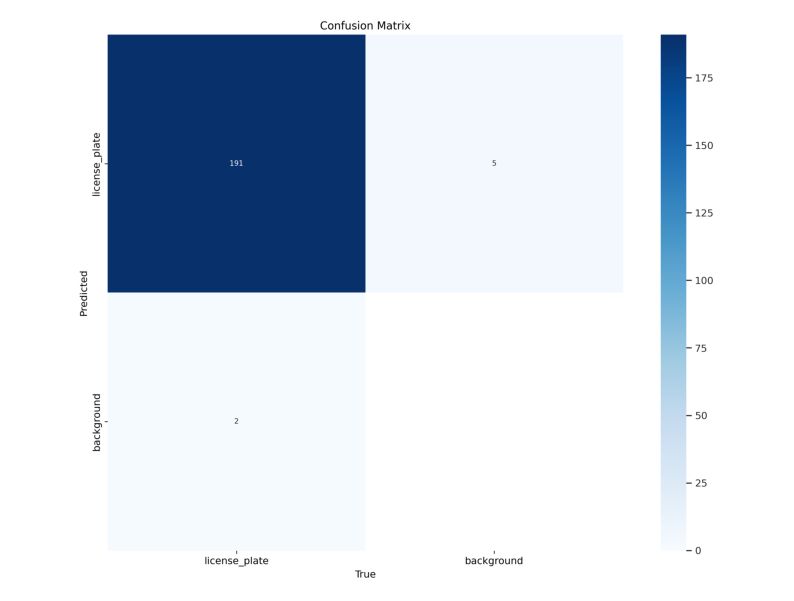

In [32]:


fig = plt.figure(figsize=(10, 9))
cm_img = mpimg.imread("/content/runs/detect/val/confusion_matrix.png")
plt.imshow(cm_img)
plt.axis("off")
fig.show()



Text(0.55, 0.93, 'Testing Curve')

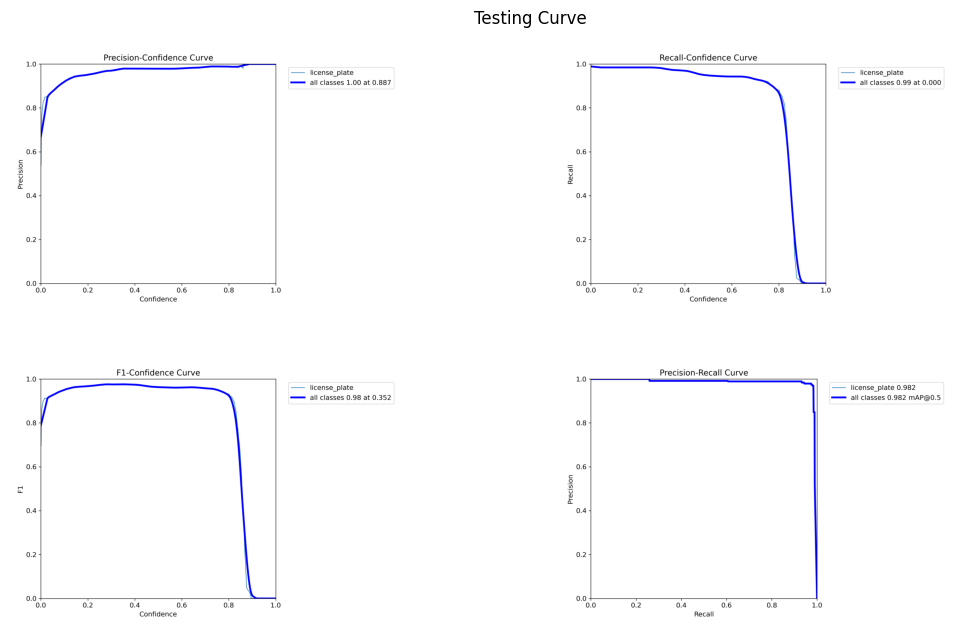

In [33]:
fig, axs = plt.subplots(2, 2, figsize=(13, 7.5))
curve_list = ["P_curve", "R_curve", "F1_curve", "PR_curve"]
for i, curve in enumerate(curve_list):
    curve_path = "/content/runs/detect/val/{}.png".format(curve)
    curve_img = mpimg.imread(curve_path)
    axs[i//2, i%2].imshow(curve_img)
    axs[i//2, i%2].axis('off')

# Title
plt.suptitle("Testing Curve", x=0.55, y=0.93)

# Show

In [34]:
df_results = df_test[["filename", "plate_number", "xmin", "ymin", "xmax", "ymax"]]
df_results = df_results.rename(columns={"filename": "image_path", "xmin": "x1_bbox", "ymin": "y1_bbox", "xmax": "x2_bbox", "ymax": "y2_bbox"})
df_results = df_results.reset_index(drop=True)
df_results

,image_path,plate_number,x1_bbox,y1_bbox,x2_bbox,y2_bbox
0,/content/State-wise_OLX/MH/MH23.jpg,MH49AS5099,108,145,164,157
1,/content/State-wise_OLX/SK/SK11.jpg,SK02P1078,90,293,161,308
2,/content/State-wise_OLX/DN/DN1.jpg,DN09H2191,95,208,174,225
3,/content/google_images/f7621229-eebc-4dff-aef8...,MH20CS1938,185,209,247,231
4,/content/google_images/car-wbs-TN21BZ0768_0000...,TN21BZ0768,79,116,121,128
...,...,...,...,...,...,...
188,/content/State-wise_OLX/TS/TS6.jpg,TS18T3899,110,145,155,156
189,/content/google_images/car-wbs-MH20BN3525_0000...,MH20BN3525,112,199,286,239
190,/content/State-wise_OLX/NL/NL2.jpg,NL01CB433,77,303,178,332
191,/content/google_images/77d1f81a-bee6-487c-aff2...,MH15TC554,582,280,699,315


In [36]:


# Get Bounding Box Predictions
from ultralytics import YOLO

yolo_model = YOLO('/content/runs/detect/train2/weights/best.pt')
bbox_results = yolo_model.predict(list(df_results["image_path"]), verbose=False)
all_box_list = []
all_conf_list = []
for bbox_result in bbox_results:
    boxes = bbox_result.boxes
    box_list = []
    conf_list = []
    for box in boxes:
        box_data = box.data[0][:4]
        box_data = [int(x) for x in box_data]
        conf = round(float(box.conf), 2)
        if(conf>=0.5):
            box_list.append(box_data)
            conf_list.append(conf)

    all_box_list.append(box_list)
    all_conf_list.append(conf_list)



In [37]:
df_results["pred_bbox"] = all_box_list
df_results["confidence"] = all_conf_list
df_results

,image_path,plate_number,x1_bbox,y1_bbox,x2_bbox,y2_bbox,pred_bbox,confidence
0,/content/State-wise_OLX/MH/MH23.jpg,MH49AS5099,108,145,164,157,"[[108, 144, 164, 157]]",[0.84]
1,/content/State-wise_OLX/SK/SK11.jpg,SK02P1078,90,293,161,308,"[[90, 292, 160, 306]]",[0.83]
2,/content/State-wise_OLX/DN/DN1.jpg,DN09H2191,95,208,174,225,"[[95, 207, 173, 224]]",[0.84]
3,/content/google_images/f7621229-eebc-4dff-aef8...,MH20CS1938,185,209,247,231,"[[184, 209, 247, 230]]",[0.84]
4,/content/google_images/car-wbs-TN21BZ0768_0000...,TN21BZ0768,79,116,121,128,"[[79, 116, 121, 128]]",[0.87]
...,...,...,...,...,...,...,...,...
188,/content/State-wise_OLX/TS/TS6.jpg,TS18T3899,110,145,155,156,"[[110, 144, 156, 156]]",[0.81]
189,/content/google_images/car-wbs-MH20BN3525_0000...,MH20BN3525,112,199,286,239,"[[117, 202, 284, 240]]",[0.76]
190,/content/State-wise_OLX/NL/NL2.jpg,NL01CB433,77,303,178,332,"[[77, 300, 178, 332]]",[0.76]
191,/content/google_images/77d1f81a-bee6-487c-aff2...,MH15TC554,582,280,699,315,"[[583, 281, 696, 314]]",[0.86]


/content/State-wise_OLX/SK/SK11.jpg


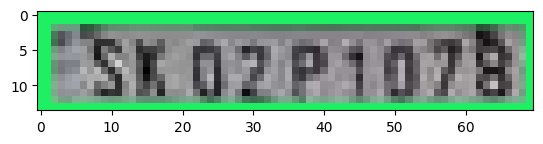

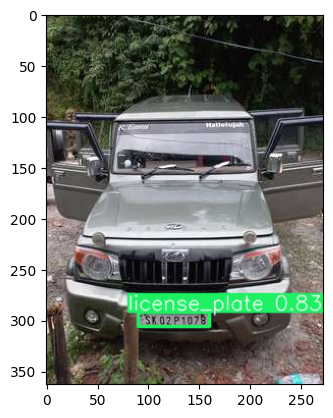

/content/State-wise_OLX/DN/DN1.jpg


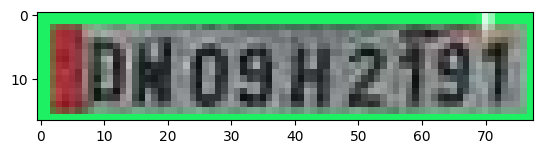

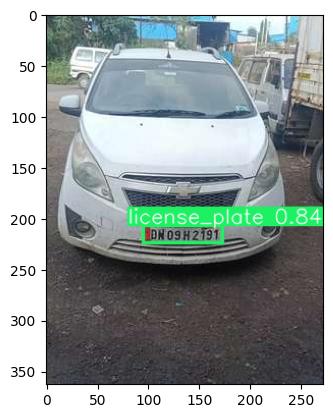

/content/google_images/f7621229-eebc-4dff-aef8-e79fac571be4___Skoda-Octavia-5.jpg.jpeg


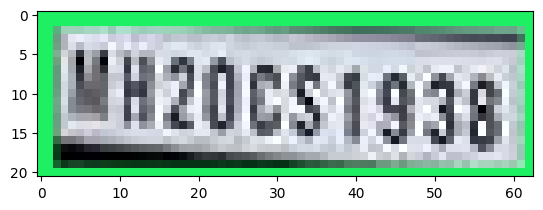

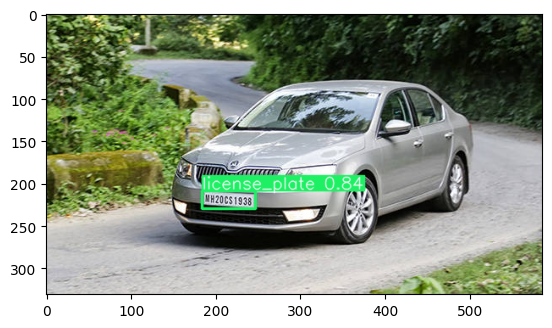

/content/google_images/car-wbs-TN21BZ0768_00001.png


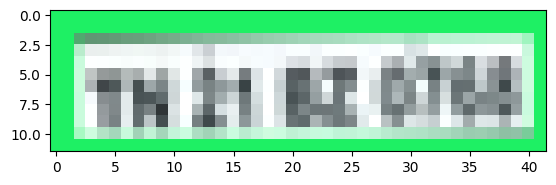

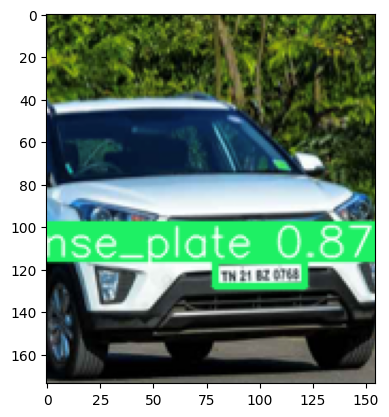

/content/State-wise_OLX/UP/UP3.jpg


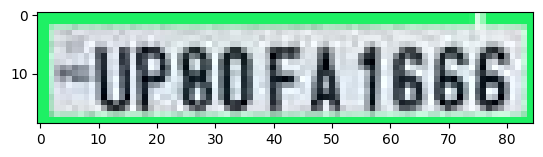

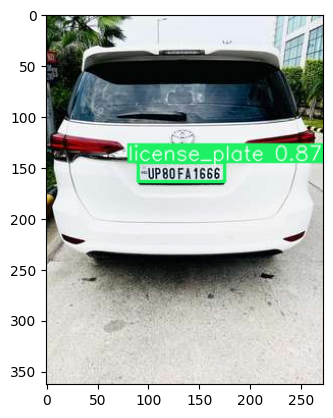

In [38]:
##to check if image has license plate or not, after this OCR scan will be done to find out the exact plate no.

from ultralytics.utils.plotting import Annotator

def show_plate_detection(idx):
    # Original Image
    ori_path = df_results["image_path"][idx]
    print(ori_path)
    ori_image = cv2.imread(ori_path)
    ori_image = cv2.cvtColor(ori_image, cv2.COLOR_BGR2RGB)

    # Annotate Box
    annotator = Annotator(ori_image)
    boxes = df_results["pred_bbox"][idx]
    confs = df_results["confidence"][idx]
    for i, box in enumerate(boxes):
        annotator.box_label(box=box, label="license_plate " + (str(confs[i])), color=(30, 240, 100))

        # Get Plate Object
        x1, y1, x2, y2 = box
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        roi = ori_image[y1:y2, x1:x2]
        plt.imshow(roi)
        plt.show()

    # Show Image
    frame = annotator.result()
    plt.imshow(frame)
    plt.show()

idxs = [1, 2, 3, 4, 5]
for idx in idxs:
    show_plate_detection(idx)



In [39]:
import cv2

# Khởi tạo VideoCapture để đọc video từ webcam hoặc tệp video
cap = cv2.VideoCapture(0)  # Sử dụng 0 để đọc từ webcam, hoặc đường dẫn đến tệp video

while True:
    # Đọc frame từ video
    ret, frame = cap.read()

    if not ret:
        break

    # Tọa độ của hai ô vuông
    x1_oto = 100
    y1_oto = 100
    x2_oto = x1_oto + 200
    y2_oto = y1_oto + 150

    x1_onho = 400
    y1_onho = 100
    x2_onho = x1_onho + 100
    y2_onho = y1_onho + 75

    # Vẽ hai ô vuông lên frame
    cv2.rectangle(frame, (x1_oto, y1_oto), (x2_oto, y2_oto), (0, 255, 0), 2)
    cv2.rectangle(frame, (x1_onho, y1_onho), (x2_onho, y2_onho), (0, 0, 255), 2)

    # Ghi text lên trên ô vuông
    cv2.putText(frame, "ô tô", (x1_oto, y1_oto - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    cv2.putText(frame, "ô nhỏ", (x1_onho, y1_onho - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)

    # Hiển thị frame bằng imshow
    cv2.imshow("Video", frame)

    # Thoát nếu nhấn phím 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Giải phóng VideoCapture và đóng cửa sổ imshow
cap.release()
cv2.destroyAllWindows()

In [40]:
!pip install opencv-python pytesseract

In [41]:
import cv2
import pytesseract
import numpy as np

In [42]:
from ultralytics import YOLO
model = YOLO('/content/runs/detect/train2/weights/best.pt')  # Đường dẫn đến file trọng số của mô hình

In [45]:
img_path = '/content/drive/MyDrive/Colab Notebooks/6098183876590548747.jpg'  # Thay thế bằng đường dẫn đến ảnh của bạn
img = cv2.imread(img_path)


In [46]:
results = model.predict(img_path)  # Chạy inference
boxes = results[0].boxes  # Lấy bounding box của biển số



image 1/1 /content/drive/MyDrive/Colab Notebooks/6098183876590548747.jpg: 640x480 1 license_plate, 40.0ms
Speed: 4.1ms preprocess, 40.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)


In [49]:
print(boxes)

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.], device='cuda:0')
conf: tensor([0.7168], device='cuda:0')
data: tensor([[4.9895e+02, 8.8617e+02, 5.9920e+02, 9.7084e+02, 7.1676e-01, 0.0000e+00]], device='cuda:0')
id: None
is_track: False
orig_shape: (1280, 960)
shape: torch.Size([1, 6])
xywh: tensor([[549.0751, 928.5071, 100.2559,  84.6696]], device='cuda:0')
xywhn: tensor([[0.5720, 0.7254, 0.1044, 0.0661]], device='cuda:0')
xyxy: tensor([[498.9471, 886.1724, 599.2030, 970.8419]], device='cuda:0')
xyxyn: tensor([[0.5197, 0.6923, 0.6242, 0.7585]], device='cuda:0')


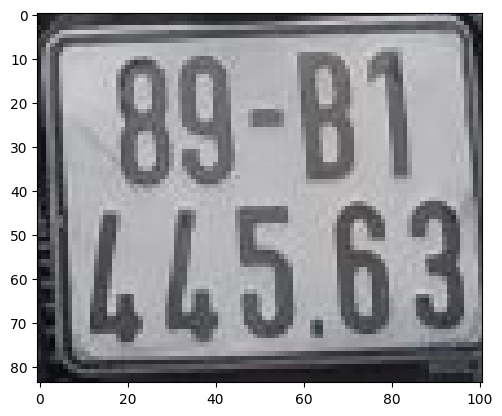

In [52]:
x1, y1, x2, y2 = boxes[0].xyxy[0].tolist()  # Tọa độ bounding box
x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
roi = img[y1:y2, x1:x2]
plt.imshow(roi)
plt.show()

In [48]:
!pip install easyocr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 912.2/912.2 kB 51.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.8/286.8 kB 23.4 MB/s eta 0:00:00


In [55]:
import easyocr
reader = easyocr.Reader(['en']) # this needs to run only once to load the model into memory
result = reader.readtext(roi)
print(result)

Progress: |██████████████████████████████████████████████████| 100.0% Complete[([[13, 5], [93, 5], [93, 45], [13, 45]], '3-81', 0.10814816206005655), ([[5, 37], [101, 37], [101, 81], [5, 81]], '15@3', 0.11123207956552505)]


In [19]:
!pip install ultralytics==8.0.122 opencv-python easyocr
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118


from ultralytics import YOLO
#from ultralytics.utils.plotting import Annotator
import easyocr
import cv2
import matplotlib.pyplot as plt


def vehicle_plate_ocr(image_path):
    """
    Detects vehicles and license plates in an image and performs OCR on the plates.

    Args:
        image_path (str): Path to the input image.

    Returns:
        list: A list of detected license plate texts.
    """

    # Load YOLO model for vehicle detection
    model_vehicle = YOLO('/content/runs/detect/train2/weights/best.pt')

    # Load YOLO model for license plate detection (you might need to train your own)
    model_plate = YOLO('/content/runs/detect/train2/weights/best.pt') # Replace with your license plate model or use pre-trained model and run inference on the vehicles

    # Initialize EasyOCR reader
    reader = easyocr.Reader(['en'])

    # Load and process the image
    #vid = cv2.imread(video_path) #cu
    #results_vehicle = model_vehicle(vid)  # Detect vehicles


    video_path = '/content/drive/MyDrive/Colab Notebooks/test5.mp4'
    cap=cv2.VideoCapture(video_path)
    assert cap.isOpened(), "Error reading video file"
#return plate_texts
    w, h, fps = (int(cap.get(x)) for x in (cv2.CAP_PROP_FRAME_WIDTH, cv2.CAP_PROP_FRAME_HEIGHT, cv2.CAP_PROP_FPS))

    out = cv2.VideoWriter("/content/drive/MyDrive/Colab Notebooks/bababa.mp4",
                        cv2.VideoWriter_fourcc(*'mp4v'),
                        fps,
                        (w, h))



    cv2.VideoCapture("/content/drive/MyDrive/Colab Notebooks/test5.mp4")
    #return plate_texts
    while cap.isOpened():
        success, frame = cap.read()
        if not success:
            break



            #frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB
        plate_texts = []
        # Perform vehicle detection
        results_vehicle = model_vehicle(frame)

        # Process detected vehicles
        for result in results_vehicle:
            for *box, conf, cls in result.boxes.data.tolist():
                if cls == 2: # vehicle class in COCO dataset, change accordingly if using a custom dataset
                    # Crop vehicle region
                    x1, y1, x2, y2 = map(int, box)
                    roi = img[y1:y2, x1:x2]

                    # Detect license plates within the vehicle region
                    results_plate = model_plate(roi)


                    for *plate_box, plate_conf, plate_cls in results_plate.boxes.data.tolist():
                        if plate_cls == 0:  # Assuming license plate class is 0 or replace with custom class id
                            # Crop license plate region
                            px1, py1, px2, py2 = map(int, plate_box)
                            roi = roi[py1:py2, px1:px2]

                            # Perform OCR on the license plate region
                            ocr_result = reader.readtext(roi)

                            if ocr_result:
                                plate_text = ocr_result[0][1]  # Get the detected text
                                plate_texts.append(plate_text)

                                # Draw bounding box and display OCR result
                                annotator = Annotator(img)
                                annotator.box_label(box, label=f"{plate_text} {plate_conf:.2f}", color=(0, 255, 0))
                                img = annotator.result()


                                cv2.putText(frame, plate_text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)



                                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
        out.write(frame)



# Example usage
video_path = '/content/drive/MyDrive/Colab Notebooks/test5.mp4'  # Replace with your image path
detected_plates = vehicle_plate_ocr(video_path)
print("Detected License Plates:", detected_plates)

Looking in indexes: https://download.pytorch.org/whl/cu118


/usr/local/lib/python3.10/dist-packages/ultralytics/nn/tasks.py:518: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(file, map_location='cpu'), file  # load


Detected License Plates: None


In [47]:
for box in boxes:
    x1, y1, x2, y2 = box.xyxy[0].tolist()  # Tọa độ bounding box
    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
    plate_img = img[y1:y2, x1:x2]  # Cắt vùng biển số

    # Thực hiện OCR bằng Tesseract
    plate_text = pytesseract.image_to_string(plate_img, config='--psm 11')
    print("Biển số:", plate_text)

    # Ghi text lên ảnh
    cv2.putText(img, plate_text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

TesseractNotFoundError: tesseract is not installed or it's not in your PATH. See README file for more information.

In [ ]:
output_path = 'path/to/save/output.jpg'  # Đường dẫn để lưu ảnh đầu ra
cv2.imwrite(output_path, img)

In [ ]:
import cv2
import pytesseract
import numpy as np
from ultralytics import YOLO
from sort import Sort  # Import SORT tracker
from PIL import Image, ImageTk
import tkinter as tk
from tkinter import filedialog
from datetime import datetime
from threading import Thread

# Class xử lý video
class VideoProcessor:
    def __init__(self, video_source, text_widget):
        self.video_source = video_source
        self.text_widget = text_widget
        self.running = False
        self.model = YOLO('yolov8n.pt')  # Sử dụng mô hình YOLOv8 nhỏ
        self.tracker = Sort()  # Khởi tạo SORT tracker
        pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'  # Đường dẫn Tesseract

    def process_video(self, video_label):
        cap = cv2.VideoCapture(self.video_source)
        while self.running and cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # Nhận diện biển số xe trong khung hình
            results = self.model(frame)
            plate_texts = []
            boxes = []

            for result in results:
                for box in result.boxes:
                    x1, y1, x2, y2 = map(int, box.xyxy[0])  # Đảm bảo các giá trị tọa độ là số nguyên
                    cropped_plate = frame[y1:y2, x1:x2]
                    gray_plate = cv2.cvtColor(cropped_plate, cv2.COLOR_BGR2GRAY)
                    _, thresh_plate = cv2.threshold(gray_plate, 150, 255, cv2.THRESH_BINARY)
                    plate_text = pytesseract.image_to_string(thresh_plate, config='--psm 8')
                    plate_texts.append(plate_text.strip())
                    cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Vẽ hình chữ nhật quanh biển số
                    boxes.append([x1, y1, x2, y2])  # Lưu bounding box để tracker theo dõi

            # Convert boxes to NumPy array
            boxes = np.array(boxes)  # Convert list of boxes to a NumPy array

            # Cập nhật SORT tracker với các bounding box mới
            tracked_objects = self.tracker.update(boxes)  # Truyền bounding boxes cho tracker

            # Hiển thị kết quả nhận diện biển số và ID theo dõi
            if tracked_objects is not None:
                for i in range(len(tracked_objects)):
                    x1, y1, x2, y2, track_id = tracked_objects[i]  # Lấy ID theo dõi
                    cv2.putText(frame, f"ID: {int(track_id)}", (int(x1), int(y1 - 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
                    # Lọc và hiển thị biển số xe đã nhận diện
                    if plate_texts:
                        plate_text = plate_texts[i].replace(' ', '')  # Xóa khoảng trắng
                        cv2.putText(frame, plate_text, (int(x1), int(y2 + 20)), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

            # Chuyển đổi khung hình thành RGB và hiển thị lên giao diện
            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            img = ImageTk.PhotoImage(Image.fromarray(rgb_frame))
            video_label.config(image=img)
            video_label.image = img

            # Hiển thị văn bản biển số xe trong text box
            if plate_texts:
                self.text_widget.delete(1.0, tk.END)
                self.text_widget.insert(tk.END, "\n".join(plate_texts))

        cap.release()

    def stop(self):
        self.running = False


# Giao diện người dùng
class App:
    def __init__(self, root):
        self.root = root
        self.root.title("Nhận diện biển số xe")
        self.processor = None

        # Hiển thị ngày giờ và địa điểm
        self.time_label = tk.Label(root, text="", font=("Arial", 12))
        self.time_label.pack(pady=5)
        self.update_time()

        # Nút chọn video và sử dụng camera
        self.btn_select_video = tk.Button(root, text="Chọn video", command=self.select_video)
        self.btn_select_video.pack(pady=5)

        self.btn_use_camera = tk.Button(root, text="Sử dụng camera", command=self.use_camera)
        self.btn_use_camera.pack(pady=5)

        # Khung hiển thị video
        self.video_label = tk.Label(root)
        self.video_label.pack(pady=5)

        # Hộp văn bản hiển thị kết quả nhận diện
        self.text_widget = tk.Text(root, height=5, width=40, font=("Arial", 10))
        self.text_widget.pack(pady=5)

    def update_time(self):
        now = datetime.now()
        day_name = "Chủ Nhật" if now.weekday() == 6 else "Thứ " + str(now.weekday() + 2)
        formatted_time = f"{day_name}, ngày {now.day} tháng {now.month} năm {now.year} {now.strftime('%I:%M %p')}"
        self.time_label.config(text=f"{formatted_time}\nCầu Giấy, Hà Nội, Việt Nam")
        self.root.after(60000, self.update_time)  # Cập nhật mỗi phút

    def select_video(self):
        video_path = filedialog.askopenfilename(title="Chọn video", filetypes=[("Video Files", "*.mp4;*.avi")])
        if video_path:
            self.start_processing(video_path)

    def use_camera(self):
        self.start_processing(0)  # Sử dụng camera mặc định

    def start_processing(self, source):
        if self.processor:
            self.processor.stop()
        self.processor = VideoProcessor(source, self.text_widget)
        self.processor.running = True
        Thread(target=self.processor.process_video, args=(self.video_label,), daemon=True).start()

    def on_closing(self):
        if self.processor:
            self.processor.stop()
        self.root.destroy()


if __name__ == "__main__":
    root = tk.Tk()
    app = App(root)
    root.protocol("WM_DELETE_WINDOW", app.on_closing)
    root.mainloop()